# Using vectorized doubles
(by Dario Izzo)

In this notebook we show how to use vectorized gduals and their performance gain.

Vectorized gduals compute on numpy arrays or iterables as polynomial coefficients. This allows to perform the same computation over $n$ different reference points without having to pay $n$ times for overheads during the polynomial multiplication algorithm powering audi and to make use of parallelization when possible.

## Importing stuff

In [1]:
from pyaudi import gdual_vdouble as gdualv
from pyaudi import gdual_double as gduald
from pyaudi import sin, cos
import numpy as np

## The test case

In [2]:
# This is a simple computation to be performed. Can be as complex as you want it to be. For this tutorial we use
# a fairly simple case.
def my_computation(x,y):
    return 1. / (x - y + 2.3)**10
# These are the reference points where we want to compute our Taylor expansion.
n = 2000
order = 20
x0  = np.linspace(0,1,n)
y0 = np.linspace(-1,1,n)

## Operating on doubles
To compute *my_computation* for all of the point defined above we need to loop over the data

In [3]:
import time
start_time = time.time()
for i in range(n):
    x = gduald(x0[i], "x", order)
    y = gduald(x0[i], "y", order)
    res = my_computation(x,y)
print("--- %s seconds ---" % (time.time() - start_time))


--- 7.584710597991943 seconds ---


## Operating on vectorized doubles
To compute *my_computation* for all of the point defined above we only perform once the computation directly on the numpy array

In [4]:
import time
start_time = time.time()
x = gdualv(x0, "x", order)
y = gdualv(y0, "y", order)
res = my_computation(x,y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.20646977424621582 seconds ---


## A deeper look into the speedup
The speedup obtained with respect to the algebraic computation performed on floats is dramatic and needs further explanation. It is important to recognize that:

 * Most of the speedup is due to inefficiencies in the gdual_double rather than tricks in the gdual_vdouble
 * The gdual_vdouble is able to exploit more efficiently the underlying CPU architecture and thus the results may vary greatly between architectures.
 * When operating with gdual_double the python overhead (i.e the interface between c++ code and python) is paid multiple times. Using gdual_vdouble this overhead is paid only once. As a limit case, there are situations where gdual_vdouble (at order 0) are more efficient than double (yes double, not gdual_double).

Lets build a better picture of the speedup one can obtain varying the order and the number of points

In [23]:
# We compute the speedup for different data sizes
n = [1, 50, 100, 500, 1000, 5000, 10000]
# And order of truncation
order = np.arange(1, 20, 2)
speedup = np.zeros([len(n),len(order)])

In [24]:
# We perform again the computations and measure speedup for each order, data size value.
print("Data size: ")
for i in range(len(n)):
    # We define the points
    x0  = np.linspace(0,1,n[i])
    y0 = np.linspace(-1,1,n[i])
    for j in range(len(order)):
        # First we compute on doubles for all points
        start_time = time.time()
        for k in range(n[i]):
            x = gduald(x0[k], "x", int(order[j]))
            y = gduald(x0[k], "y", int(order[j]))
            dummy = my_computation(x,y)
        res = (time.time() - start_time)
        start_time = time.time()
        x = gdualv(x0, "x", int(order[j]))
        y = gdualv(y0, "y", int(order[j]))
        dummy = my_computation(x,y)
        res = (res / (time.time() - start_time))
        speedup[i,j] = res
    print(n[i], end = ", ")



Data size: 
1, 50, 100, 500, 1000, 5000, 10000, 

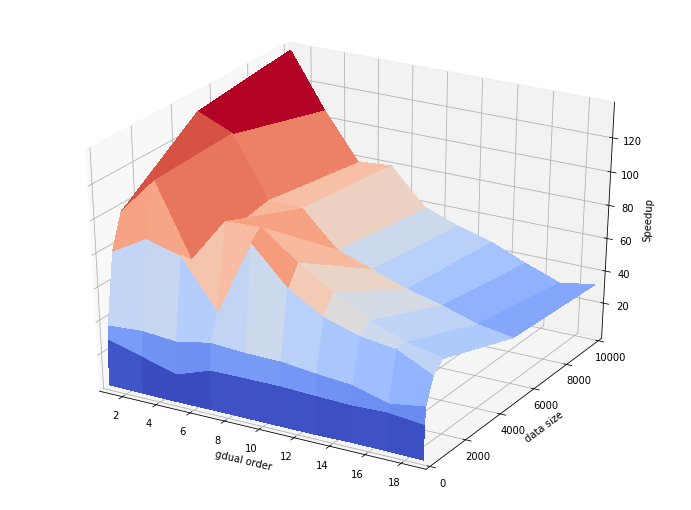

In [25]:
# And we plot the results
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# Make data.
X, Y = np.meshgrid(order, n)
Z = speedup

# Prepare the plot
fig = plt.figure(figsize=(12, 9))
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('gdual order')
ax.set_ylabel('data size')
ax.set_zlabel('Speedup')
plt.xlim([1,19])
plt.ylim([0,10000])
plt.show()
